# Análise exploratória de dados

> Jean Cardoso, Ph.D.

## Carregando dados

In [201]:
# Carregando o notebook externo
!pip install -q import-ipynb
!pip install -q kmodes

In [265]:
import import_ipynb

#from google.colab import drive
#drive.mount('/content/drive')

# Caminho para o notebook `plots.ipynb` no Google Drive
notebook_path = '/content/drive/MyDrive/case_rentcars/case_rentcars/plots.ipynb'

In [266]:
# Importando as funções do notebook
import nbformat
from nbconvert import PythonExporter

with open(notebook_path) as f:
    nb = nbformat.read(f, as_version=4)

exporter = PythonExporter()
source, _ = exporter.from_notebook_node(nb)
exec(source)

In [267]:
# Carregando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud
from pathlib import Path
from scipy.stats import f_oneway
import statsmodels.api as sm
from kmodes.kprototypes import KPrototypes
warnings.filterwarnings('ignore')

In [268]:
# Carregando o conjunto de dados
aisles = pd.read_csv('/content/drive/MyDrive/case_rentcars/data/interim/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/case_rentcars/data/interim/departments.csv')
products = pd.read_csv('/content/drive/MyDrive/case_rentcars/data/interim/products.csv')
orders = pd.read_csv('/content/drive/MyDrive/case_rentcars/data/interim/orders.csv')

prior = pd.read_csv('/content/drive/MyDrive/case_rentcars/data/interim/order_products__prior.csv')
train = pd.read_csv('/content/drive/MyDrive/case_rentcars/data/interim/order_products__train.csv')

## Compreendendo o conjunto de dados

In [269]:
# aisle_id: Identificador único do corredor.
# aisle: Nome do corredor
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [270]:
# department_id: Identificador único do departamento.
# department: Nome do departamento.
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [271]:
# product_id: Identificador único do produto.
# product_name: Nome do produto.
# aisle_id: Identificador do corredor ao qual o produto pertence.
# department_id: Identificador do departamento ao qual o produto pertence.
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [272]:
# order_id: Identificador único do pedido.
# user_id: Identificador único do usuário (cliente).
# eval_set: Conjunto de avaliação do pedido (prior para pedidos anteriores, train
# para treinamento, test para teste).
# order_number: Número do pedido (sequência de pedidos feitos pelo usuário).
# order_dow: Dia da semana em que o pedido foi feito (0 = domingo, 1 = segunda-feira, etc.).
# order_hour_of_day: Hora do dia em que o pedido foi feito (0-23).
# days_since_prior_order: Dias desde o último pedido (NaN para o primeiro pedido).
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [273]:
# order_id = 2: Identifica um pedido específico.
# product_id = 33120: O primeiro produto adicionado ao carrinho neste pedido.
# product_id = 28985: O segundo produto adicionado ao carrinho neste pedido.
# product_id = 9327: O terceiro produto adicionado ao carrinho neste pedido.
# add_to_cart_order: Indica a ordem em que os produtos foram adicionados ao carrinho
# reordered = 1: Indica que o produto foi recomprado (já havia sido comprado anteriormente
# pelo usuário).
# reordered = 0: Indica que o produto foi comprado pela primeira vez pelo usuário.
print(prior.shape)
prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [274]:
# order_id: Identificador único do pedido (relativo ao conjunto de treinamento).
# product_id: Identificador único do produto.
# add_to_cart_order: Posição do produto no carrinho (por ordem de adição).
# reordered: Indicador de recompra (1 se o produto foi recomprado, 0 se foi
# comprado pela primeira vez).
print(train.shape)
train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Primeiras análises

### 1. Mesclando os dados aisles, departments e products.

In [275]:
# Mesclar dados de produtos com corredores e departamentos
merged_data = pd.merge(products, aisles, on='aisle_id')
retail_catalog = pd.merge(merged_data, departments, on='department_id')
retail_catalog.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


In [276]:
# Criar um DataFrame com as contagens
summary_df = pd.DataFrame({
    'Quantidade': ['Produtos', 'Corredores', 'Departamentos'],
    'Total': [len(retail_catalog['product_name'].unique()),
              len(retail_catalog['aisle'].unique()),
              len(retail_catalog['department'].unique())]
})

# Exibir a tabela
display(summary_df)

,Quantidade,Total
0,Produtos,49688
1,Corredores,134
2,Departamentos,21


In [277]:
aisle_counts = retail_catalog['aisle'].value_counts()
department_counts = retail_catalog['department'].value_counts()
product_counts = retail_catalog['product_name'].value_counts()

Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/qtd_prod_cor.png


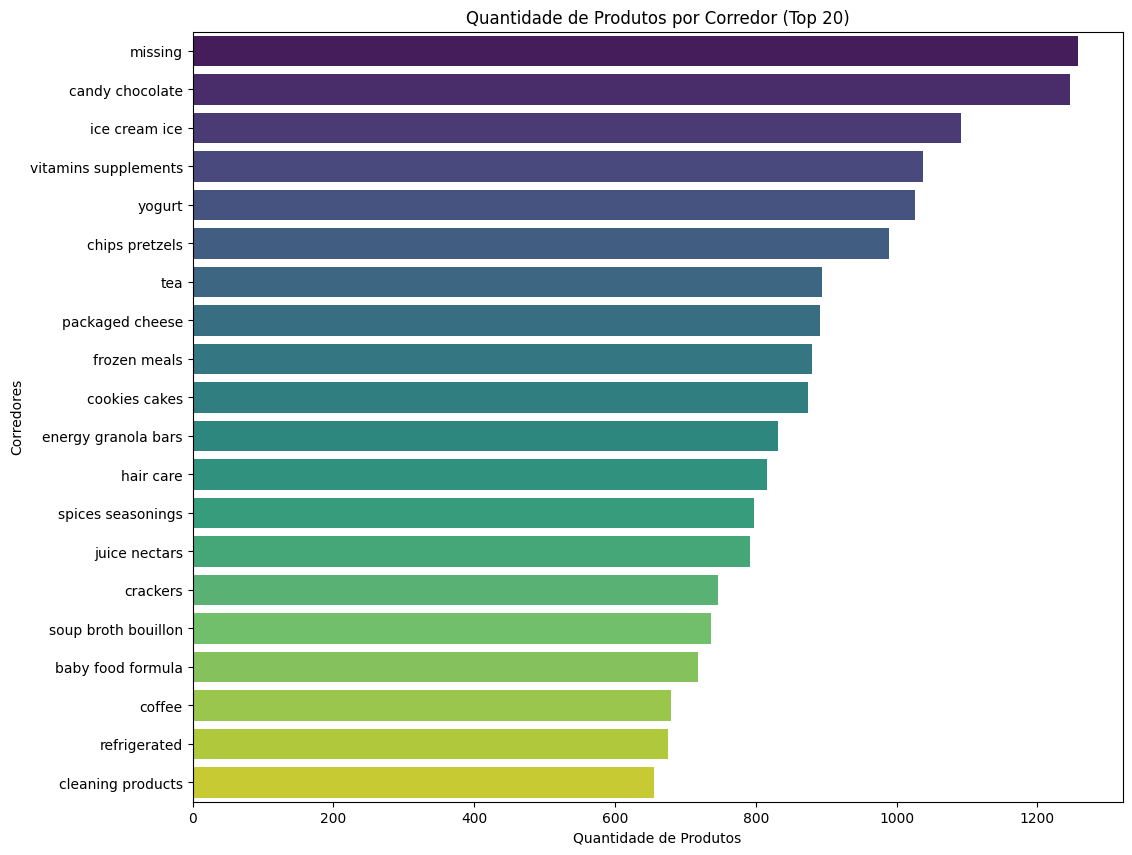

In [278]:
plot_data(plot_type='bar',
          x=aisle_counts.values[:20],
          y=aisle_counts.index[:20],
          palette='viridis',
          title='Quantidade de Produtos por Corredor (Top 20)',
          xlabel='Quantidade de Produtos',
          ylabel='Corredores',
          filename='qtd_prod_cor.png',
          save_plot=True)

1. Corredores com mais Produtos:
- O corredor "missing" tem a maior quantidade de produtos. Isso pode indicar produtos que não foram corretamente classificados.

2. Categorias Populares:
- Corredores como "candy chocolate" e "ice cream ice" sugerem que produtos de sobremesa e doces têm uma alta presença no inventário.
- A presença de corredores como "vitamins supplements" e "hair care" indica uma boa variedade de produtos de saúde e cuidados pessoais.

Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/qtd_prod_dep.png


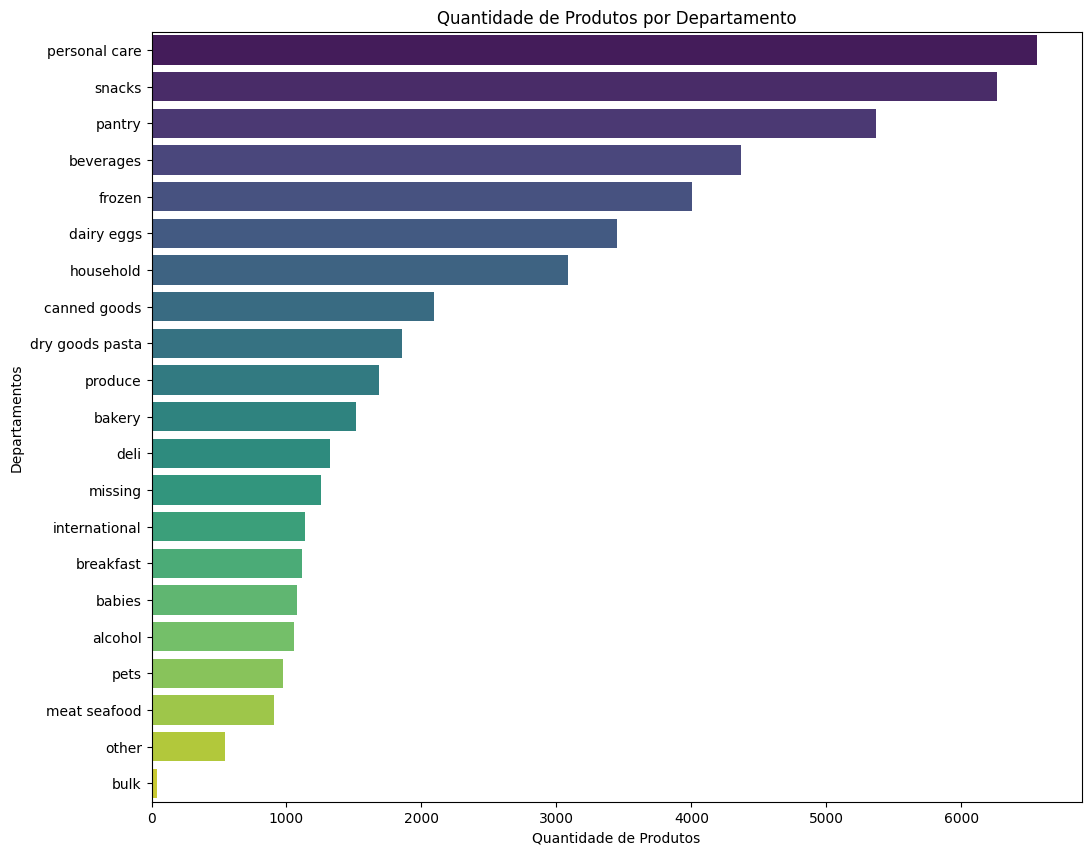

In [279]:
plot_data(plot_type='bar',
          x=department_counts.values,
          y=department_counts.index,
          palette='viridis',
          title='Quantidade de Produtos por Departamento',
          xlabel='Quantidade de Produtos',
          ylabel='Departamentos',
          filename='qtd_prod_dep.png',
          save_plot=True)

1. Departamentos com mais Produtos:
- Personal Care: O departamento de cuidados pessoais tem o maior número de produtos, indicando uma ampla variedade de itens como shampoos, sabonetes, produtos de higiene, entre outros.
- Snacks: O departamento de lanches também tem um grande número de produtos, sugerindo uma alta demanda por esses itens.
- Pantry: Produtos de despensa (como alimentos não perecíveis) estão em terceiro lugar, refletindo a necessidade contínua de itens básicos na alimentação diária.

2. Gerenciamento de Categorias Populares:
- Alta Diversidade em Personal Care: A ampla variedade de produtos de cuidados pessoais pode ser uma resposta à alta demanda e preferências variadas dos consumidores.
- Snacks e Beverages: Departamentos de lanches e bebidas são áreas chave para promoções sazonais, como durante eventos esportivos ou feriados.

In [280]:
# Contagem de corredores únicos por departamento
aisles_per_department = retail_catalog.groupby('department')['aisle'].nunique()

# Ordenar os valores para melhor visualização
aisles_per_department = aisles_per_department.sort_values(ascending=False)

Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/qtd_cor_dep.png


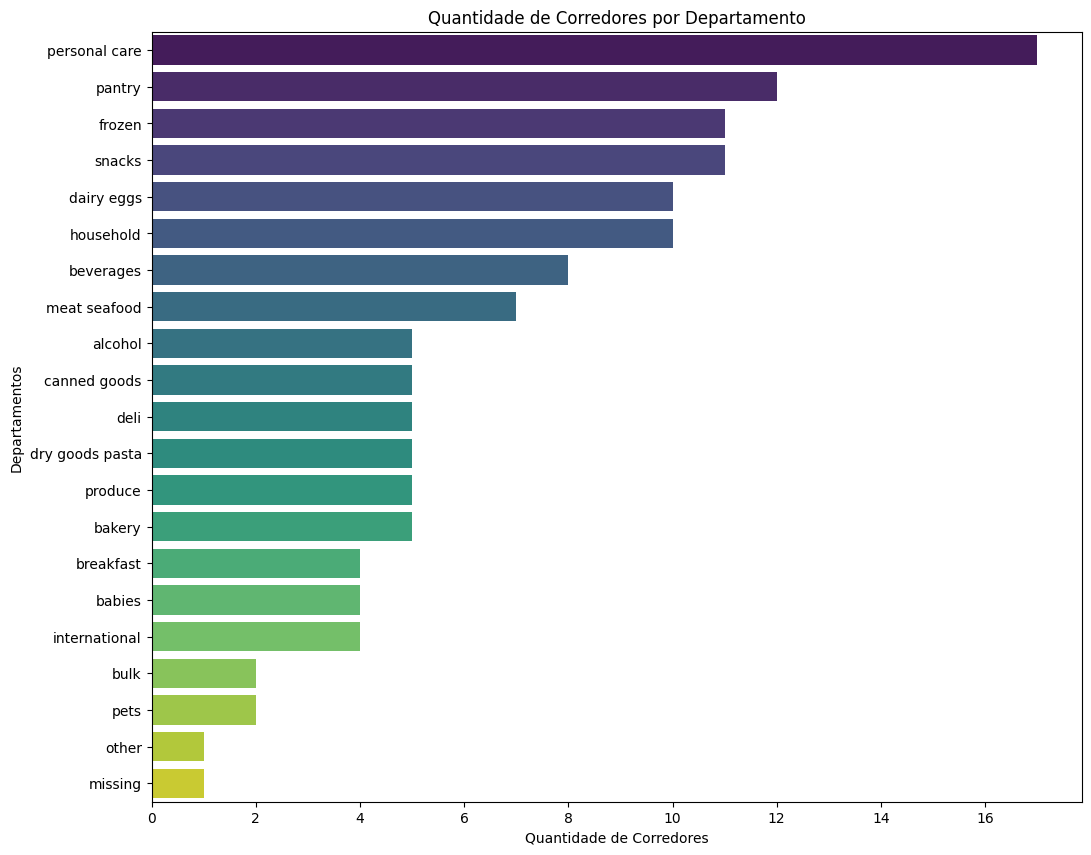

In [281]:
# Plot: Quantidade de corredores por departamento
plot_data(plot_type='bar',
          x=aisles_per_department.values,
          y=aisles_per_department.index,
          palette='viridis',
          title='Quantidade de Corredores por Departamento',
          xlabel='Quantidade de Corredores',
          ylabel='Departamentos',
          filename='qtd_cor_dep.png',
          save_plot=True)

1. Departamentos com mais Corredores:
- Personal Care: Este departamento tem a maior quantidade de corredores, sugerindo uma alta variedade de produtos de cuidados pessoais distribuídos em múltiplos corredores.
- Pantry e Frozen: Esses departamentos também têm um número significativo de corredores, indicando uma grande diversidade de produtos não perecíveis e congelados.

2. Departamentos com menos Corredores:
- Bulk e Pets: Esses departamentos têm menos corredores, o que pode indicar uma menor variedade de produtos.

3. Estratégias de Marketing:
- Exibição de Produtos: A variedade de produtos em departamentos como "Personal Care" pode ser usada para criar seções temáticas ou displays promocionais para atrair a atenção dos clientes.

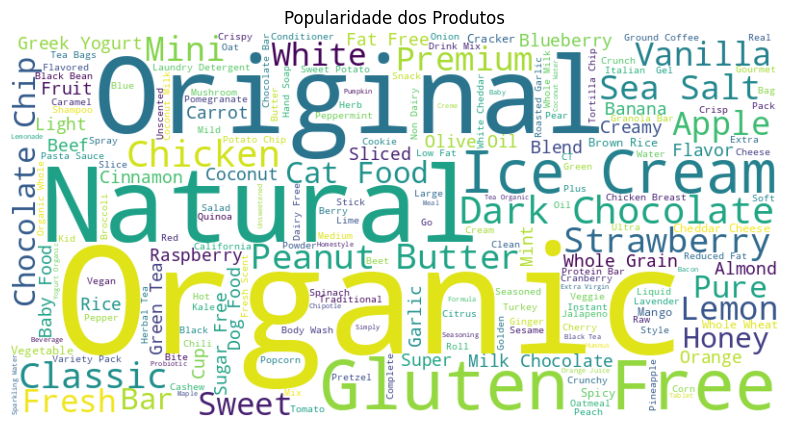

In [282]:
# Gerar uma string com todos os nomes de produtos
product_names = ' '.join(retail_catalog['product_name'])

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_names)

# Mostrar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Popularidade dos Produtos')

# Especificar o caminho completo onde você quer salvar o arquivo PDF
output_path = Path("/content/drive/MyDrive/case_rentcars/reports/figures/wordcloud.png")
# Salvar a nuvem de palavras como um arquivo PDF no diretório especificado
plt.savefig(output_path, format='png', bbox_inches='tight')

plt.show()

1. Termos Frequentes:
- "Organic" (Orgânico): Este termo é o mais proeminente na nuvem, indicando uma forte presença de produtos orgânicos no catálogo. Isso reflete uma tendência crescente entre os consumidores que preferem produtos naturais e sustentáveis.
- "Original", "Natural" e "Gluten Free" (Sem Glúten): Outros termos frequentes que indicam a popularidade de produtos em suas formas puras e naturais.

2. Variedade de Produtos:
- Alimentos Diversos: Termos como "Ice Cream", "Chicken", "Peanut Butter", "Chocolate", "Yogurt" e "Apple" destacam uma ampla gama de produtos alimentares disponíveis, desde sobremesas e lanches até alimentos básicos.
- Produtos de Saúde e Cuidados: Palavras como "Cat Food", "Dog Food", "Shampoo" e "Detergent" mostram que a oferta inclui não apenas alimentos, mas também produtos de cuidados pessoais e para animais de estimação.

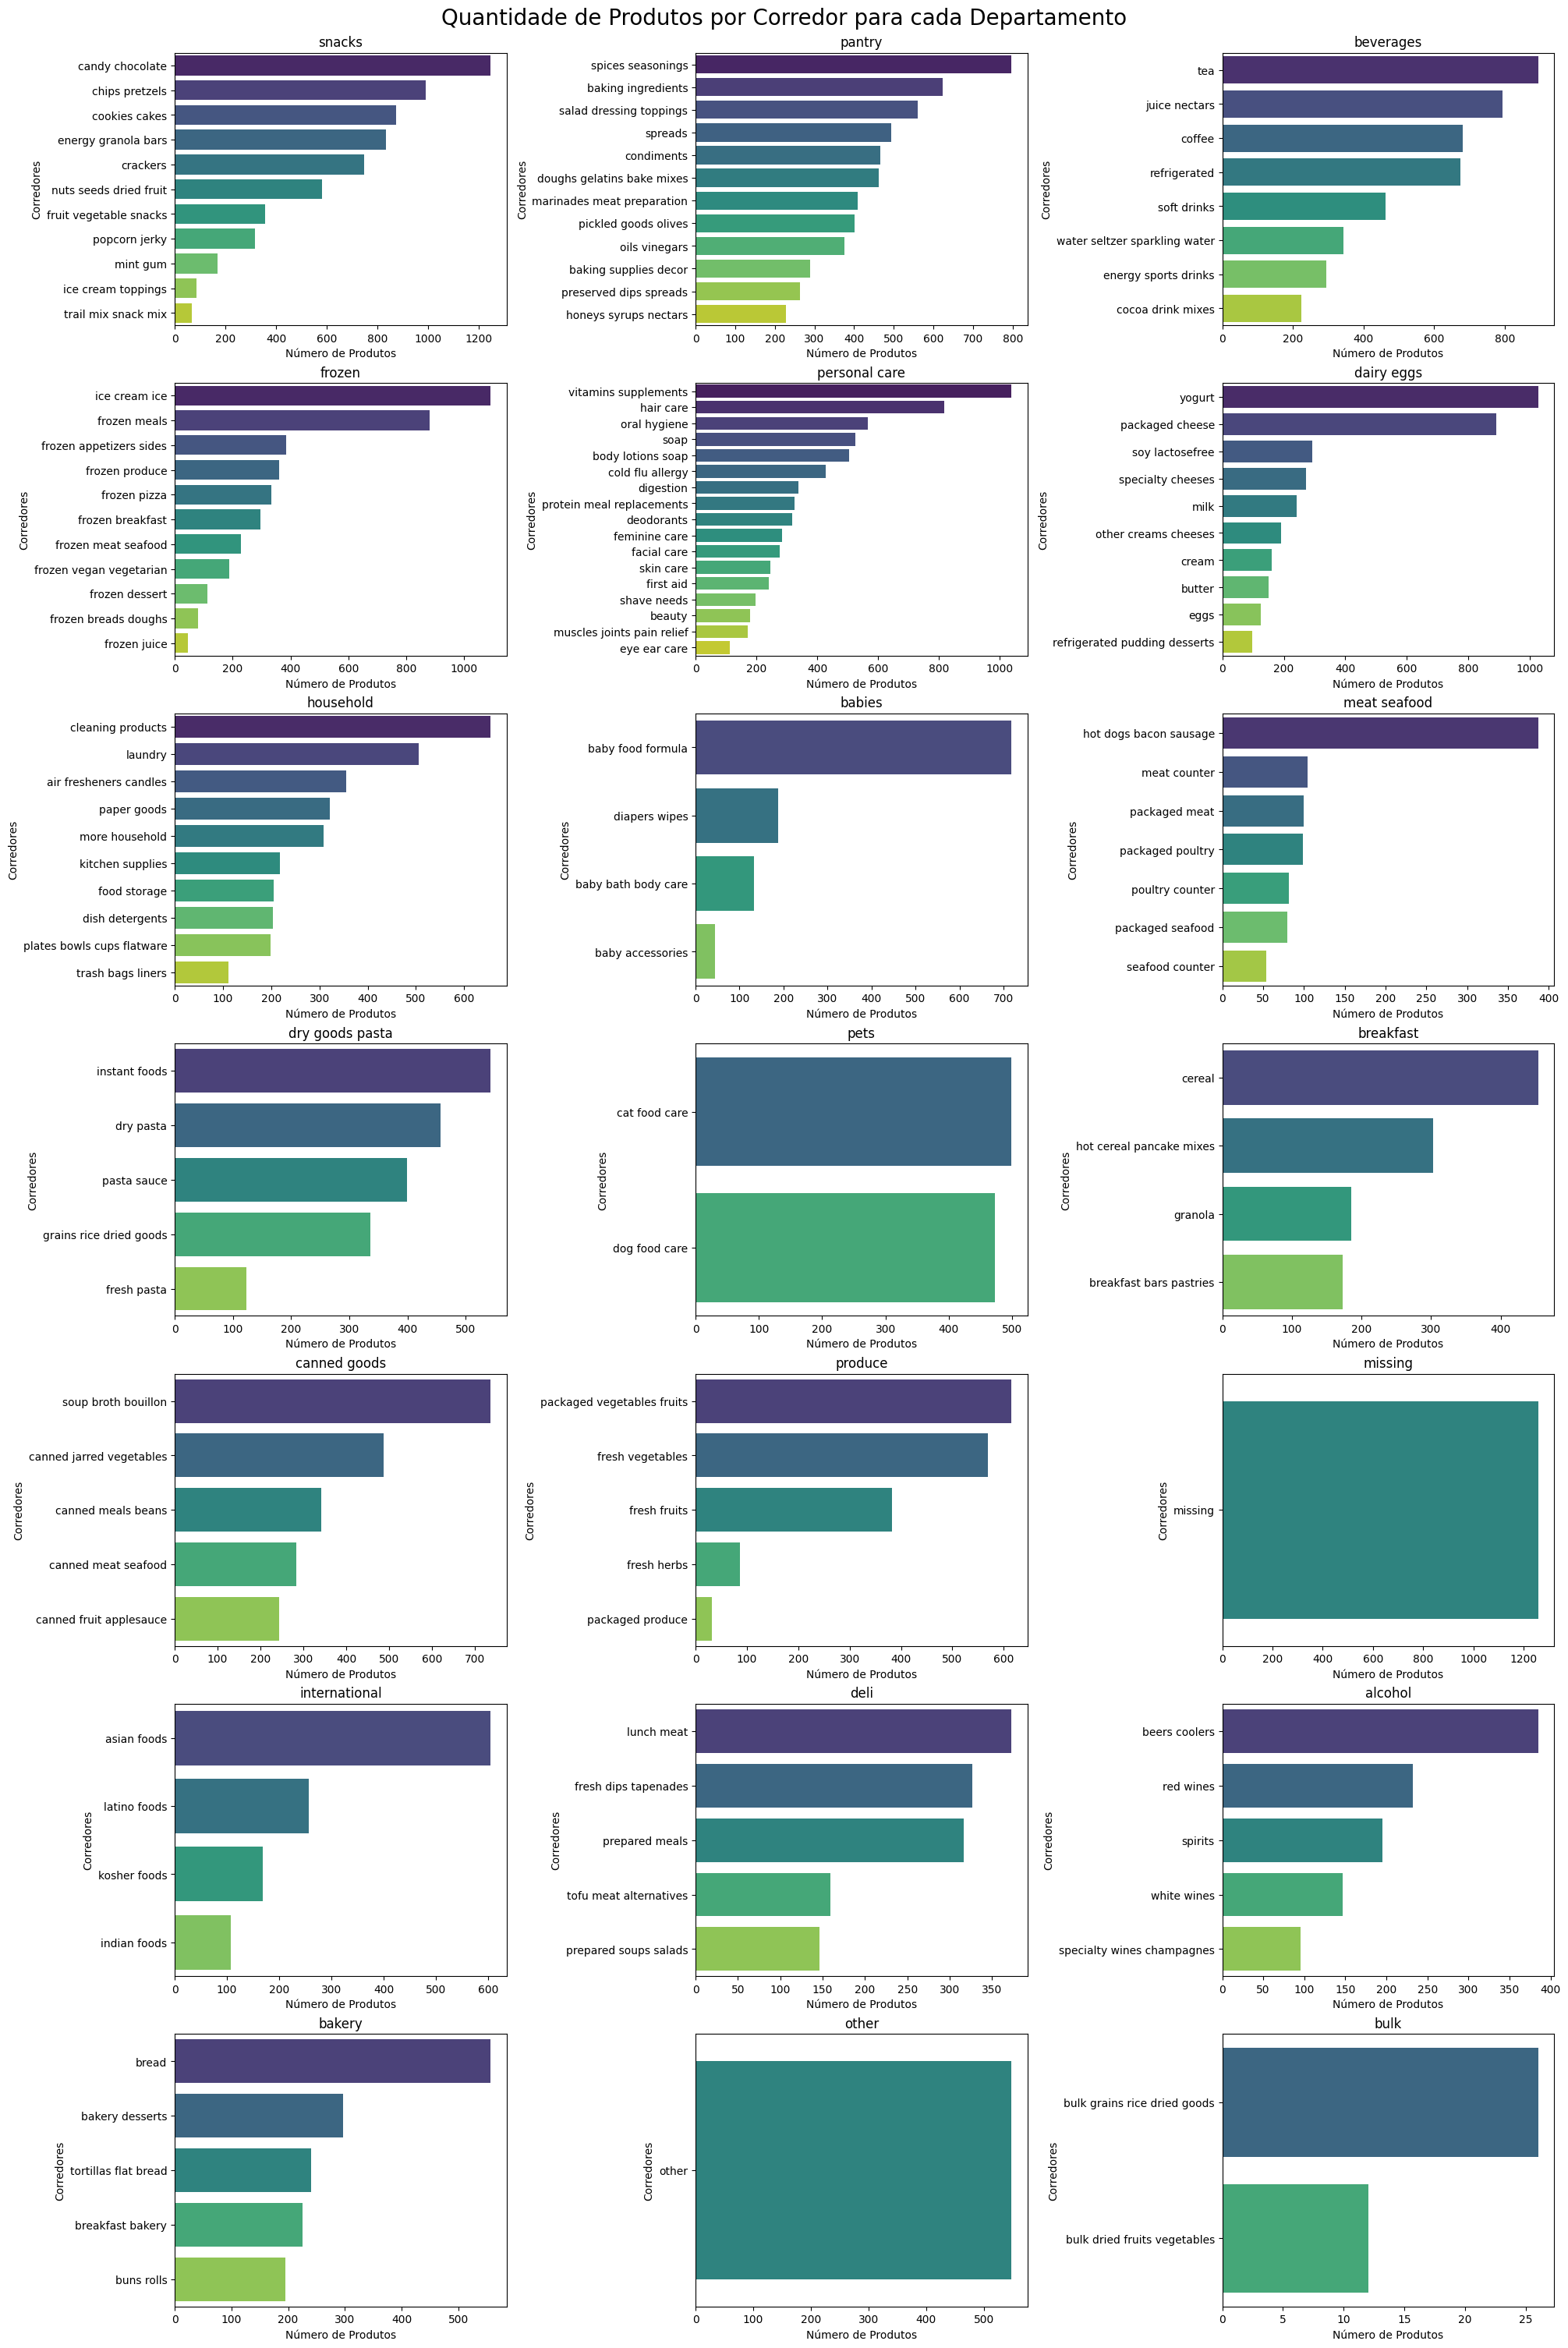

In [283]:
# Definindo o tamanho da figura
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 30), constrained_layout=True)

# Ajustando o número de departamentos para o layout de grade
departments_unique = retail_catalog['department'].unique()
num_departments = len(departments)

# Iterando sobre cada departamento e criando um gráfico
for i, department in enumerate(departments_unique):
    row = i // 3
    col = i % 3
    department_data = retail_catalog[retail_catalog['department'] == department]
    products_per_aisle = department_data['aisle'].value_counts()

    sns.barplot(x=products_per_aisle.values, y=products_per_aisle.index,
                ax=axes[row, col], hue=products_per_aisle.index,
                palette='viridis', dodge=False, legend=False)
    axes[row, col].set_title(department)
    axes[row, col].set_xlabel('Número de Produtos')
    axes[row, col].set_ylabel('Corredores')

# Removendo gráficos extras, se houver
for j in range(num_departments, 21):
    fig.delaxes(axes.flat[j])

plt.suptitle('Quantidade de Produtos por Corredor para cada Departamento', fontsize=20)

# Especificar o caminho completo para salvar o gráfico
output_path = Path("/content/drive/MyDrive/case_rentcars/reports/figures/grafico_departamentos.png")
# Salvar o gráfico como um arquivo PDF ou PNG no diretório especificado
plt.savefig(output_path, format='png', bbox_inches='tight')

plt.show()


### 2. Explorando o banco de dados orders.

In [284]:
# Contagem de pedidos por dia da semana
orders_per_dow = orders['order_dow'].value_counts().sort_index()

Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/qtd_pedidos_diasemana.png


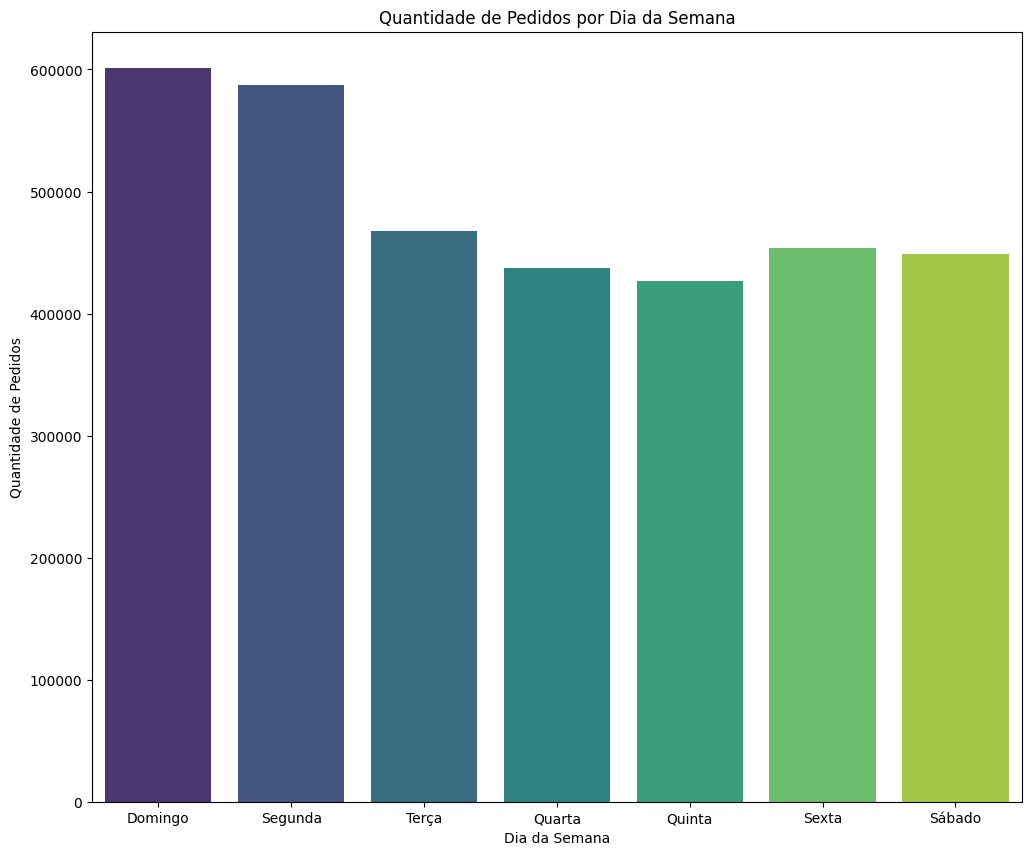

In [285]:
# Quantidade de Pedidos por Dia da Semana
plot_data(plot_type='bar',
          x=orders_per_dow.index,
          y=orders_per_dow.values,
          palette='viridis',
          title='Quantidade de Pedidos por Dia da Semana',
          xlabel='Dia da Semana',
          ylabel='Quantidade de Pedidos',
          xticks_labels= (['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado']),
          filename='qtd_pedidos_diasemana.png',
          save_plot=True)

1. Picos de Atividade:
- Domingo: O número de pedidos é mais alto aos domingos, sugerindo que este é o dia mais popular para os clientes fazerem pedidos. Isso pode ser devido à preparação para a semana seguinte.
- Segunda-feira: O segundo maior número de pedidos ocorre nas segundas-feiras, indicando que muitos clientes ainda estão completando suas compras no início da semana.

2. Dias de Menor Atividade:
- Terça-feira a Sábado: Há uma queda visível no número de pedidos durante esses dias.

3. Campanhas de Marketing:
- Promoções Alvo: Realizar promoções específicas durante os dias de menor atividade (quarta à quinta-feira) pode ajudar a distribuir a demanda de forma mais uniforme ao longo da semana.


In [286]:
# Contagem de pedidos por hora
orders_per_hour = orders['order_hour_of_day'].value_counts().sort_index()

Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/qtd_pedidos_hora.png


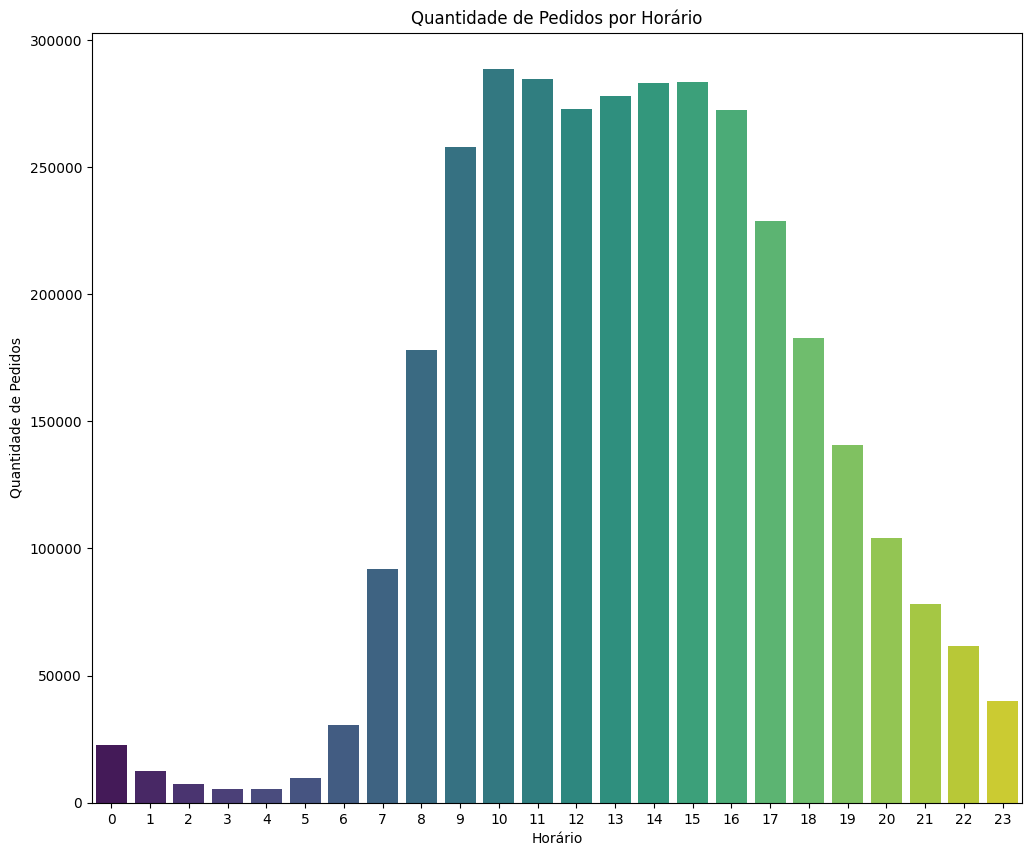

In [287]:
# Contagem de pedidos por horário
plot_data(plot_type='bar',
          x=orders_per_hour.index,
          y=orders_per_hour.values,
          palette='viridis',
          title='Quantidade de Pedidos por Horário',
          xlabel='Horário',
          ylabel='Quantidade de Pedidos',
          filename='qtd_pedidos_hora.png',
          save_plot=True)

1. Picos de Atividade:
- 9h às 16h: O maior número de pedidos ocorre entre as 9h e 16h. Isso sugere que a maioria dos clientes faz compras durante o meio do dia, provavelmente antes ou durante o horário de almoço.
- 10h e 11h: Esses horários especificamente têm o maior volume de pedidos.

2. Baixa Atividade:
- 0h às 6h: Há poucos pedidos durante a madrugada e as primeiras horas da manhã.

3. Atividade Moderada:
- 7h às 8h: Há um aumento gradual no número de pedidos a partir das 7h, sugerindo que alguns clientes começam a fazer compras logo de manhã.

4. Campanhas de Marketing:
- Promoções Matinais: Oferecer promoções especiais nas primeiras horas da manhã (por exemplo, descontos até as 9h) pode incentivar mais compras durante esse período de baixa atividade.
- Ofertas Noturnas: Implementar promoções específicas após as 20h pode ajudar a aumentar as vendas durante as horas de menor movimento.

In [288]:
# Contagem de pedidos por usuário
orders_per_user = orders.groupby('user_id')['order_number'].max()

Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/dist_qtd_pedido_usuario.png


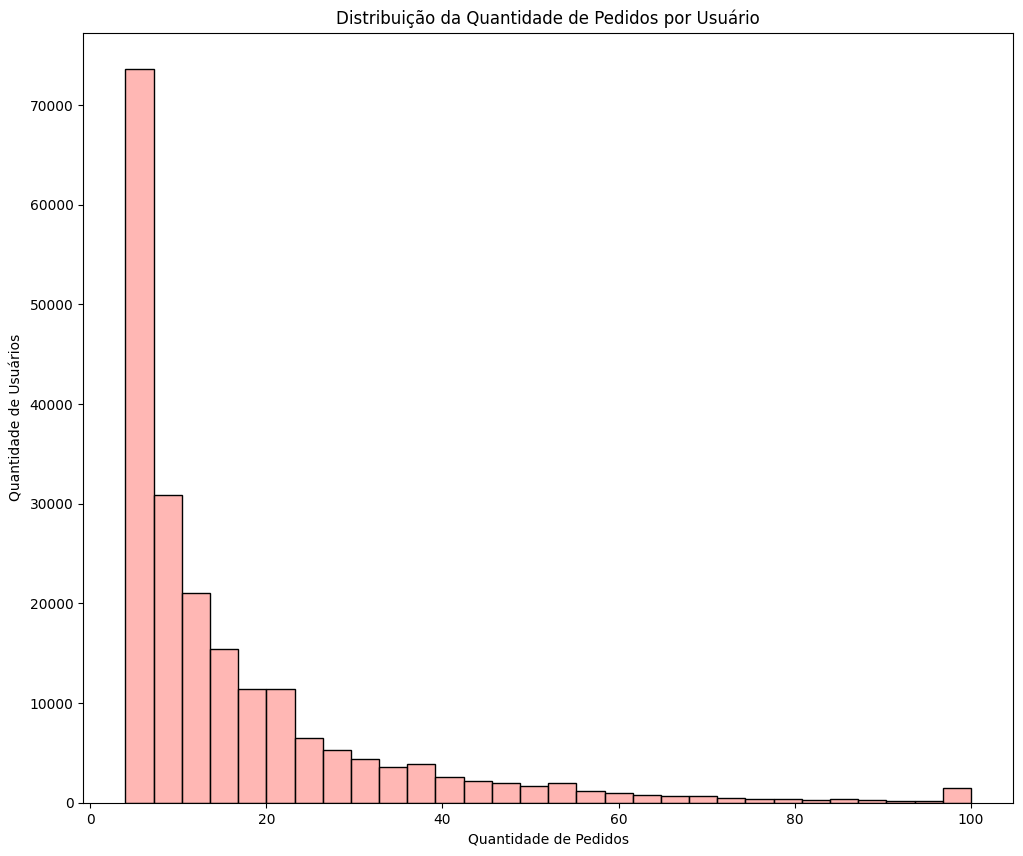

In [289]:
# Contagem de pedidos por usuário
plot_hist(x=orders_per_user,
          bins=30,
          kde=False,
          color='#ff9f9b',
          title='Distribuição da Quantidade de Pedidos por Usuário',
          xlabel='Quantidade de Pedidos',
          ylabel='Quantidade de Usuários',
          filename='dist_qtd_pedido_usuario.png',
          save_plot=True)

1. Usuários com Poucas Pedidos:
- A maioria dos usuários fez um número pequeno de pedidos.

2. Decrescimento Exponencial:
- O gráfico mostra um decrescimento exponencial, onde o número de usuários diminui rapidamente à medida que o número de pedidos aumenta. Isso indica que há menos usuários que fizeram um grande número de pedidos.

3. Usuários Frequentes:
- Há uma pequena quantidade de usuários que fizeram muitas ordens. Mesmo assim, existe uma diminuição acentuada no número de usuários conforme o número de ordens aumenta para 30 ou mais.

4. Aquisição e Retenção de Clientes:
- Alta Aquisição, Baixa Retenção: O pico acentuado em 1-2 pedidos sugere que, embora muitos usuários sejam adquiridos, a retenção pode ser um problema, pois muitos não voltam para fazer compras adicionais.
- Foco na Retenção: Investir em estratégias de retenção, como programas de fidelidade, descontos para compras repetidas, e campanhas de reengajamento, pode ajudar a aumentar o número de usuários que fazem pedidos adicionais.

5. Segmentação de Clientes:
- Clientes Novos vs. Clientes Fiéis: A segmentação dos clientes com base no número de pedidos pode ajudar a identificar novos clientes e clientes fiéis. Novos clientes podem precisar de incentivos para se tornarem clientes recorrentes.
- Campanhas Personalizadas: Desenvolver campanhas de marketing personalizadas para cada segmento pode aumentar a eficácia das campanhas. Por exemplo, oferecer um desconto para um cliente que fez apenas um pedido pode incentivá-lo a fazer um segundo pedido.

In [290]:
# Calcular a média de days_since_last_order para cada usuário
orders['days_since_last_order'] = orders.groupby('user_id')['days_since_prior_order'].shift(-1)
avg_days_since_last_order = orders.groupby('user_id')['days_since_last_order'].mean().dropna().reset_index()

# Definir segmentos
bins = [0, 7, 14, 30, np.inf]
labels = ['Muito Frequente', 'Frequente', 'Ocasional', 'Raro']
avg_days_since_last_order['segment'] = pd.cut(avg_days_since_last_order['days_since_last_order'], bins=bins, labels=labels)

# Contar o número de usuários em cada segmento
segment_counts = avg_days_since_last_order['segment'].value_counts()

Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/seg_cliente_freq_compra.png


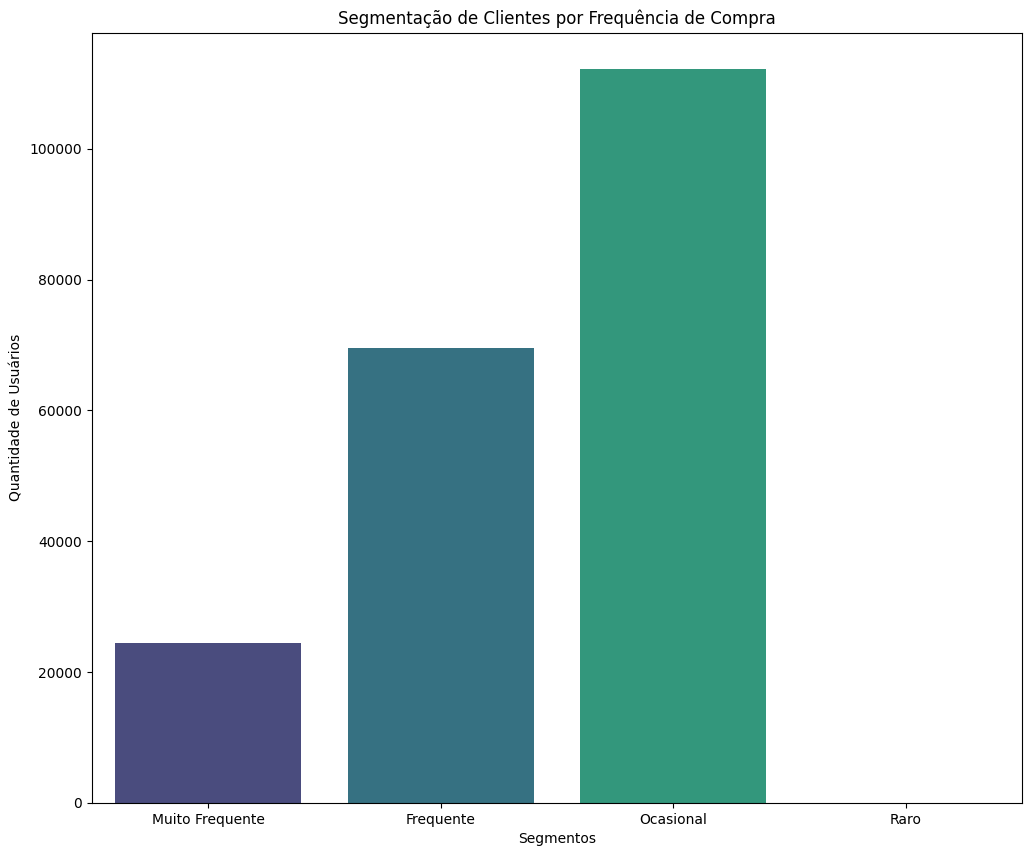

In [291]:
# Segmentação de Clientes por Frequência de Compra
plot_data(plot_type='bar',
          x=segment_counts.index,
          y=segment_counts.values,
          palette='viridis',
          title='Segmentação de Clientes por Frequência de Compra',
          xlabel='Segmentos',
          ylabel='Quantidade de Usuários',
          filename='seg_cliente_freq_compra.png',
          save_plot=True)

1. Estratégias de Retenção de Clientes:
- Foco em Clientes Frequentes e Muito Frequentes: Clientes que fazem compras frequentes são valiosos e devem ser recompensados para mantê-los engajados. Programas de fidelidade, descontos exclusivos e ofertas personalizadas podem ajudar a aumentar a retenção desses clientes.
- Reengajamento de Clientes Ocasional: A maioria dos clientes está no segmento ocasional. Oferecer incentivos para aumentar a frequência de compras, como cupons de desconto para a próxima compra ou programas de recompensas baseados na frequência de pedidos, pode ajudar a mover esses clientes para segmentos mais frequentes.

2. Campanhas de Marketing Segmentadas:
- Personalização de Ofertas: As campanhas de marketing podem ser personalizadas com base no segmento de frequência de compra. Por exemplo, campanhas de reengajamento podem ser direcionadas aos clientes ocasionais, enquanto campanhas de fidelização podem ser direcionadas aos clientes muito frequentes.

3. Análise de Comportamento de Compra:
- Identificação de Padrões: Analisar os padrões de compra dentro de cada segmento pode ajudar a entender melhor as necessidades e preferências dos clientes. Isso pode incluir estudar *quais produtos são mais populares entre clientes frequentes versus ocasionais.*



Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/dist_dias_ultimo_pedido.png


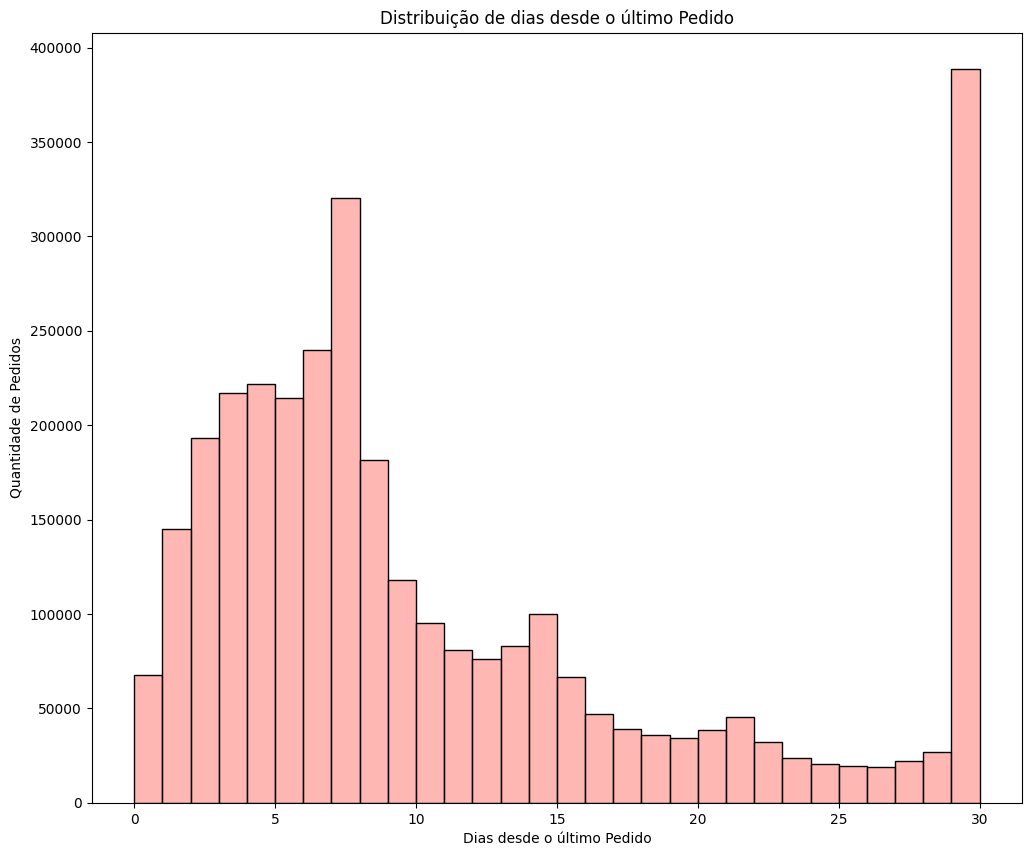

In [292]:
# Distribuição de Dias Desde o Último Pedido
plot_hist(x=orders['days_since_prior_order'],
          bins=30,
          kde=False,
          color='#ff9f9b',
          title='Distribuição de dias desde o último Pedido',
          xlabel='Dias desde o último Pedido',
          ylabel='Quantidade de Pedidos',
          filename='dist_dias_ultimo_pedido.png',
          save_plot=True)

1. Picos na Distribuição:
- Dias 7, 14 e 30: Existem picos significativos em intervalos específicos, especialmente aos 7, 14 e 30 dias. Isso sugere que muitos clientes têm ciclos de compra regulares, possivelmente semanais, quinzenais e mensais.

2. Tendências Gerais:
- Dias 1 a 10: Há uma alta frequência de pedidos logo após os primeiros dias, especialmente até o décimo dia, indicando que muitos clientes realizam compras dentro de uma a duas semanas após o pedido anterior.
- Dias 11 a 20: A frequência de pedidos diminui gradualmente, com um pequeno aumento em torno do dia 15.
- Dia 30: O número de pedidos aumenta drasticamente no dia 30, sugerindo que muitos clientes fazem compras mensais.

3. Segmentação de Clientes:
- Campanhas de Reengajamento: Clientes que tendem a fazer compras em intervalos regulares podem ser alvo de campanhas de reengajamento, oferecendo lembretes ou promoções próximas aos seus ciclos de compra típicos.



Plot saved to /content/drive/MyDrive/case_rentcars/reports/figures/analise_retencao.png


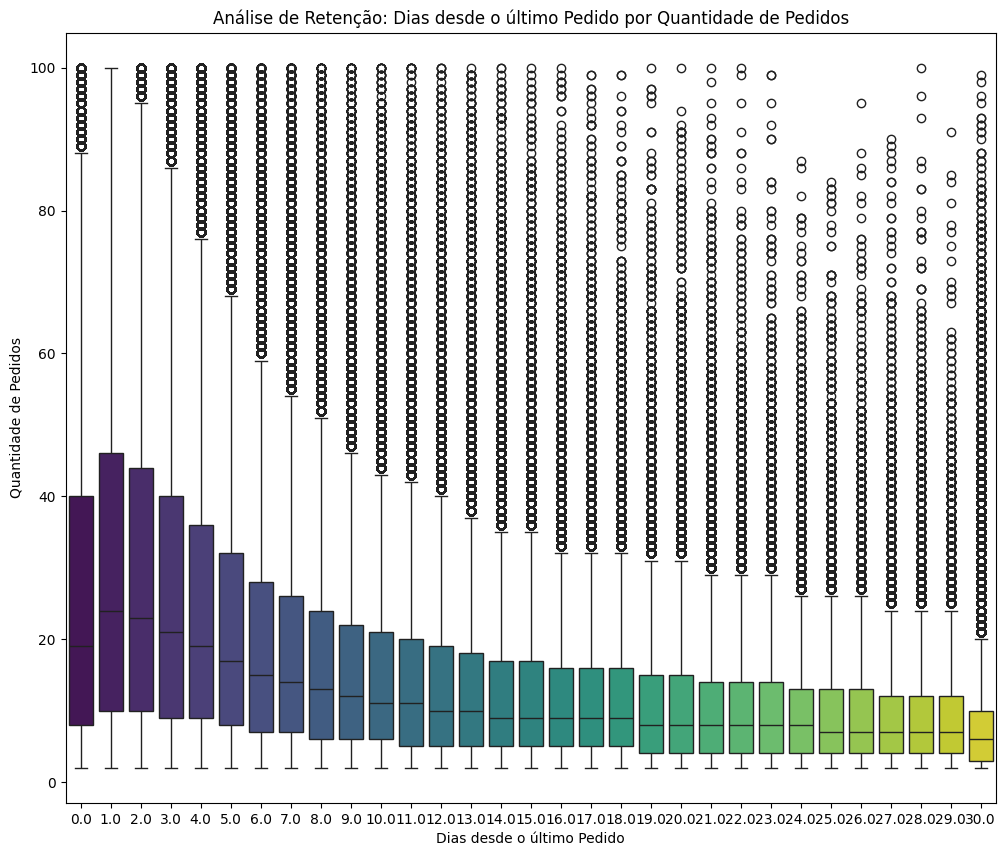

In [322]:
# Análise de Retenção: Dias Desde o Último Pedido por Número de Ordem
plot_data(plot_type='box',
          data=orders,
          x='days_since_prior_order',
          y='order_number',
          palette='viridis',
          title='Análise de Retenção: Dias desde o último Pedido por Quantidade de Pedidos',
          xlabel='Dias desde o último Pedido',
          ylabel='Quantidade de Pedidos',
          filename='analise_retencao.png',
          save_plot=True)

1. Tendência Geral:
- Diminuição dos Dias Desde o Último Pedido: À medida que o número de ordem aumenta, a mediana dos dias desde o último pedido tende a diminuir. Isso indica que, quanto mais pedidos um cliente faz, menor é o intervalo entre seus pedidos.

2. Estabilização com o Tempo:
- Estabilização da Frequência de Pedidos: Após aproximadamente 20 pedidos, a variação dos dias desde o último pedido diminui e a frequência de pedidos se estabiliza, com a maioria dos clientes fazendo pedidos em intervalos regulares.

3. Outliers:
- Presença de Outliers: Há muitos outliers presentes ao longo de todo o gráfico, indicando que há sempre alguns clientes que não seguem o padrão geral e podem ter intervalos de compra muito maiores ou muito menores.

4. Comportamento de Compra dos Clientes:
- Fidelização Gradual: À medida que os clientes fazem mais pedidos, eles tendem a se tornar mais frequentes e regulares, sugerindo que a fidelização aumenta com o tempo e com a familiaridade com o serviço.

5. Segmentação de Clientes:
- Identificação de Clientes em Risco: Clientes que, após muitos pedidos, ainda têm uma grande variação nos dias desde o último pedido podem estar em risco de churn (abandono) e podem ser alvo de campanhas de reengajamento.

6. Estratégias de Marketing e Retenção:
- Incentivos para Novos Clientes: Oferecer incentivos para reduzir os intervalos entre os primeiros pedidos pode ajudar a estabelecer um hábito de compra mais rápido.
- Recompensas para Clientes Fiéis: Desenvolver programas de fidelidade que recompensem a regularidade e frequência de pedidos pode ajudar a manter os clientes fiéis e incentivá-los a continuar comprando regularmente.

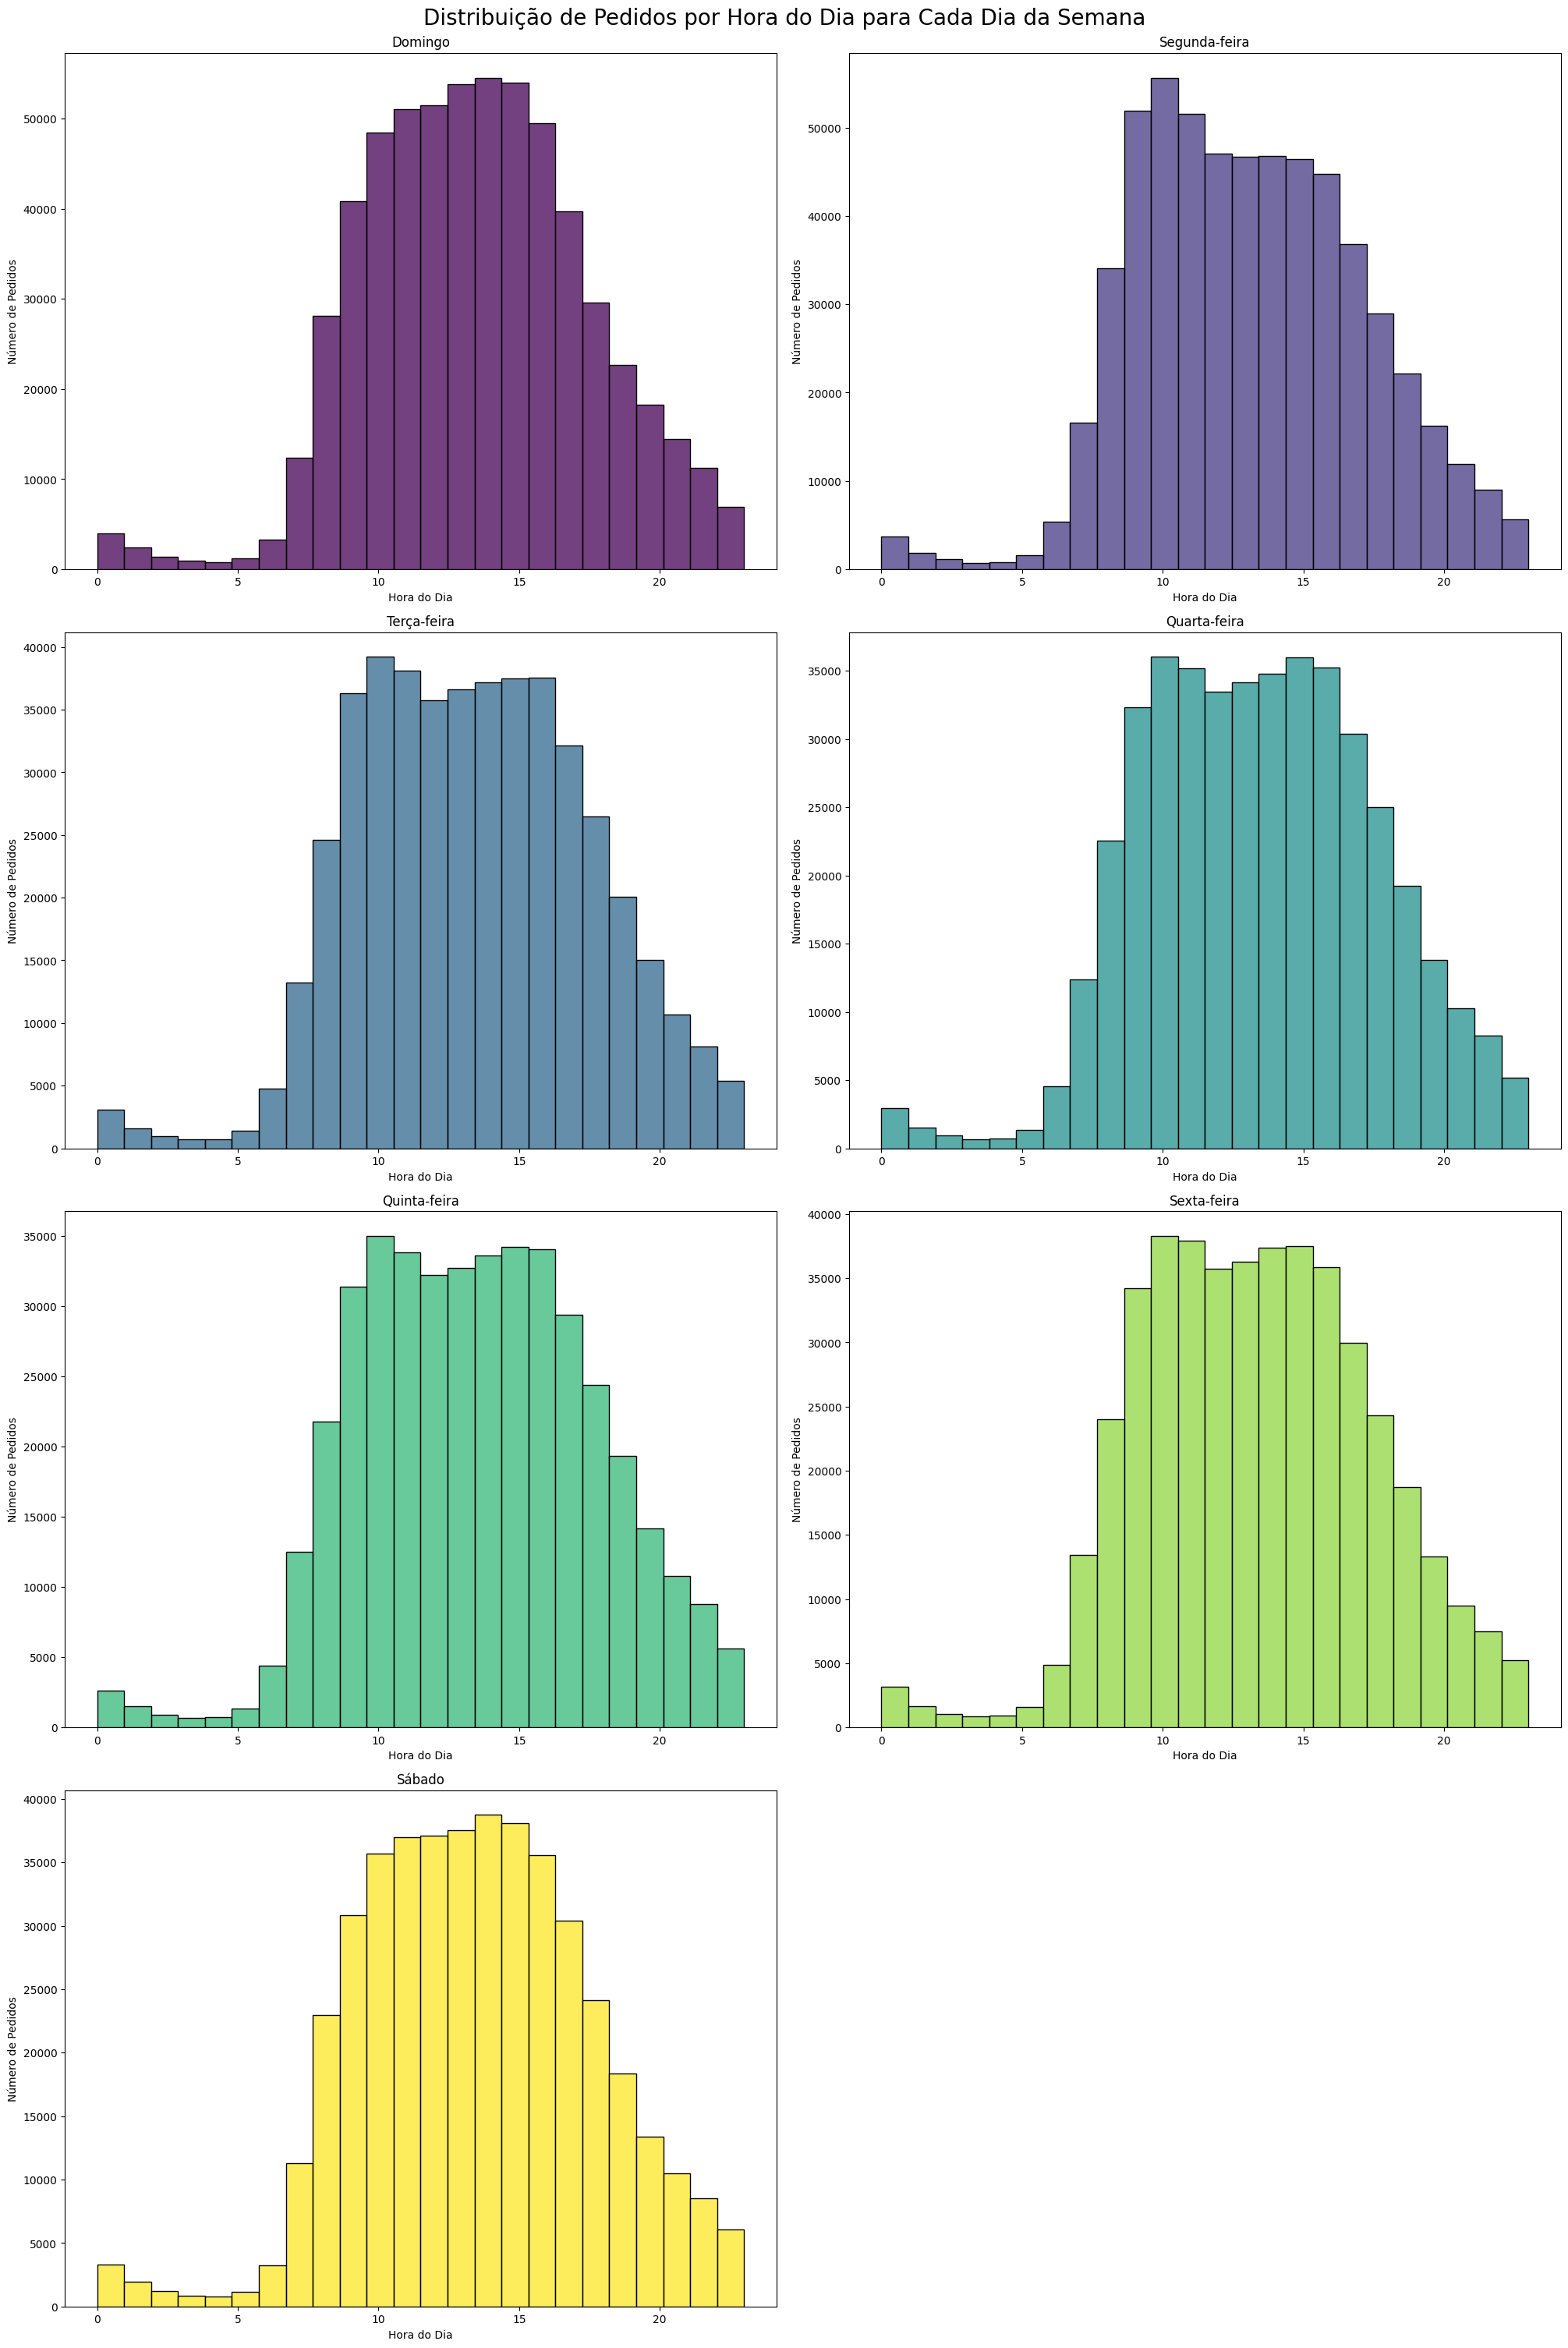

In [294]:
# Definir os dias da semana
dias_semana = ['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']

# Definir o tamanho da figura
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 30), constrained_layout=True)
axes = axes.flatten()

# Iterar sobre cada dia da semana e criar um gráfico
for i in range(7):
    dia_semana = dias_semana[i]
    dia_data = orders[orders['order_dow'] == i]

    sns.histplot(dia_data['order_hour_of_day'], bins=24, kde=False, ax=axes[i], color=sns.color_palette('viridis', as_cmap=True)(i / 6))
    axes[i].set_title(dia_semana)
    axes[i].set_xlabel('Hora do Dia')
    axes[i].set_ylabel('Número de Pedidos')

# Remover gráficos extras, se houver
for j in range(7, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribuição de Pedidos por Hora do Dia para Cada Dia da Semana', fontsize=20)

# Especificar o caminho completo onde irá salvar o gráfico
output_path = Path("/content/drive/MyDrive/case_rentcars/reports/figures/grafico_dias_da_semana.png")
# Salvar o gráfico como um arquivo PDF ou PNG no diretório especificado
plt.savefig(output_path, format='png', bbox_inches='tight')

plt.show()

### 3. Analisando dados históricos.

In [295]:
# Mesclar dados de produtos com corredores e departamentos
orders_all = pd.concat([prior, train], axis=0)
all_orders_data = pd.merge(orders_all, retail_catalog, on='product_id')

In [296]:
# Identificar os top 20 produtos mais comprados
most_bought_products = all_orders_data['product_name'].value_counts().head(20).index

# Filtrar os dados para apenas os top 20 produtos mais comprados
top_20_products_data = all_orders_data[all_orders_data['product_name'].isin(most_bought_products)]

# Obter os departamentos e corredores desses produtos
top_20_departments_aisles = top_20_products_data[['product_name', 'department', 'aisle']].drop_duplicates()

# Exibir os resultados
print("Top 20 Produtos Mais Comprados - Departamentos e Corredores:")
top_20_departments_aisles

Top 20 Produtos Mais Comprados - Departamentos e Corredores:


,product_name,department,aisle
262494,Organic Baby Spinach,produce,packaged vegetables fruits
660276,Bag of Organic Bananas,produce,fresh fruits
1056918,Organic Raspberries,produce,packaged vegetables fruits
1318865,Organic Hass Avocado,produce,fresh fruits
1842557,Banana,produce,fresh fruits
2412822,Organic Avocado,produce,fresh fruits
2683093,Organic Strawberries,produce,fresh fruits
3282453,Organic Whole Milk,dairy eggs,milk
5117953,Large Lemon,produce,fresh fruits
5526270,Organic Yellow Onion,produce,fresh vegetables


In [297]:
# Identificar os top 20 produtos menos comprados
least_bought_products = all_orders_data['product_name'].value_counts().tail(20).index

# Filtrar os dados para apenas os top 20 produtos menos comprados
top_20_least_bought_data = all_orders_data[all_orders_data['product_name'].isin(least_bought_products)]

# Obter os departamentos e corredores desses produtos
top_20_least_bought_departments_aisles = top_20_least_bought_data[['product_name', 'department', 'aisle']].drop_duplicates()

# Exibir os resultados
print("Top 20 Produtos Menos Comprados - Departamentos e Corredores:")
top_20_least_bought_departments_aisles


Top 20 Produtos Menos Comprados - Departamentos e Corredores:


,product_name,department,aisle
33465953,Blueberry Blast Fruit and Chia Seed Bar,snacks,energy granola bars
33723209,Yellow Fish Breading,pantry,marinades meat preparation
33735384,Citronge Extra Fine Orange Liqueur,alcohol,spirits
33736653,"1,000 Mg Vitamin C Tangerine Grapefruit Efferv...",beverages,energy sports drinks
33800808,String Of Pearl White Sprinkles,pantry,baking supplies decor
33803646,Pasta Shapes In Tomato Sauce,missing,missing
33803665,Multigrain Penne Rigate,dry goods pasta,dry pasta
33804887,All Natural Stevia Liquid Extract Sweetener,pantry,baking ingredients
33812163,Escapes Variety Pack,alcohol,beers coolers
33815364,Original Lager,alcohol,beers coolers


1. Diversidade de Depatamentos:
- Na primeira tablema podemos notar uma predominância do departamento produce e dos corredores fresh fruits.
- Ao contrário dos produtos mais comprados, os produtos menos comprados são distribuídos por uma maior variedade de departamentos.

2. Identificação de Produtos de Baixa Rotatividade:
- Os produtos listados têm baixa rotatividade, o que pode indicar uma baixa demanda. Isso pode ser devido à falta de necessidade regular, produtos menos populares ou pouco conhecidos.

In [298]:
# Identificar os top 20 produtos mais recomprados
most_reordered_products = all_orders_data[all_orders_data['reordered'] == 1]['product_name'].value_counts().head(20).index

# Filtrar os dados para apenas os top 20 produtos mais recomprados
top_20_reordered_data = all_orders_data[all_orders_data['product_name'].isin(most_reordered_products)]

# Obter os departamentos e corredores desses produtos
top_20_reordered_departments_aisles = top_20_reordered_data[['product_name', 'department', 'aisle']].drop_duplicates()

# Exibir os resultados
print("Top 20 Produtos Mais Recomprados - Departamentos e Corredores:")
top_20_reordered_departments_aisles

Top 20 Produtos Mais Recomprados - Departamentos e Corredores:


,product_name,department,aisle
262494,Organic Baby Spinach,produce,packaged vegetables fruits
660276,Bag of Organic Bananas,produce,fresh fruits
1056918,Organic Raspberries,produce,packaged vegetables fruits
1318865,Organic Hass Avocado,produce,fresh fruits
1842557,Banana,produce,fresh fruits
2412822,Organic Avocado,produce,fresh fruits
2683093,Organic Strawberries,produce,fresh fruits
3007285,Organic Half & Half,dairy eggs,cream
3282453,Organic Whole Milk,dairy eggs,milk
5117953,Large Lemon,produce,fresh fruits


1. Importância de Frutas e Vegetais Frescos:
- A alta frequência de frutas e vegetais frescos nos produtos mais recomprados indica que esses itens são essenciais nas compras recorrentes dos consumidores.
Corredores como "fresh fruits" e "fresh vegetables" são críticos para a loja.

2. Oportunidades de Expansão:
- Promover produtos de outros departamentos junto com produtos frescos e orgânicos pode aumentar a venda cruzada e a diversificação das compras dos consumidores

In [299]:
# Identificar os top 20 produtos menos recomprados
least_reordered_products = all_orders_data[all_orders_data['reordered'] == 1]['product_name'].value_counts().tail(20).index

# Filtrar os dados para apenas os top 20 produtos menos recomprados
top_20_least_reordered_data = all_orders_data[all_orders_data['product_name'].isin(least_reordered_products)]

# Obter os departamentos e corredores desses produtos
top_20_least_reordered_departments_aisles = top_20_least_reordered_data[['product_name', 'department', 'aisle']].drop_duplicates()

# Exibir os resultados
print("Top 20 Produtos Menos Recomprados - Departamentos e Corredores:")
display(top_20_least_reordered_departments_aisles)

Top 20 Produtos Menos Recomprados - Departamentos e Corredores:


,product_name,department,aisle
33513658,Witch Hazel For Face & Body,personal care,first aid
33513774,Lemon Dishwashing Detergent + Clorox Stain Fig...,household,dish detergents
33513798,"Chili with Beans, Vegetarian",canned goods,canned meals beans
33514398,"Cognac, Privilege V.S.O.P",alcohol,spirits
33514661,Coconut Hibiscus Conditioner,personal care,hair care
33516035,Ultra Antibacterial Dish Liquid,missing,missing
33715263,Cocktail Time Hummus,deli,fresh dips tapenades
33715270,Sun-Dried Tomato Garlic,canned goods,canned jarred vegetables
33761995,Decorating Sugar Raspberry Red,pantry,baking supplies decor
33762055,Arctic Cod Liver Oil Lemon,personal care,vitamins supplements


1. Diversidade de Departamentos:
- Os produtos menos recomprados são distribuídos por uma variedade de departamentos, como "household", "personal care", "meat seafood", "beverages", "pantry", "canned goods", "deli" e "dry goods pasta".

2. Presença de Produtos Específicos e de Uso Ocasional
- Muitos desses produtos são itens específicos ou de uso ocasional. Produtos de nicho, como "Decaf Sweet Coconut Thai Chai Tea" e "Pomegranate Pizzazz Herbal Tea Bags Caffeine Free", também aparecem na lista.

3. Estratégias de Marketing Direcionadas:
- Para aumentar as vendas desses produtos, estratégias de marketing específicas podem ser implementadas. Isso pode incluir promoções ou descontos.
- Posicionamento estratégico na loja virtual, como destacar esses produtos em seções de "Novidades" ou "Ofertas Especiais", pode ajudar a aumentar a visibilidade.

In [300]:
# Calcular o número de produtos por pedido
products_per_order = all_orders_data.groupby('order_id')['product_name'].count().reset_index()
products_per_order.columns = ['order_id', 'num_products']

# Calcular a média
mean_num_products = products_per_order['num_products'].mean()

# Calcular a moda
mode_num_products = products_per_order['num_products'].mode()[0]

# Calcular a mediana
median_num_products = products_per_order['num_products'].median()

# Exibir os resultados
print(f"Média do número de produtos por pedido: {mean_num_products:.2f}")
print(f"Moda do número de produtos por pedido: {mode_num_products}")
print(f"Mediana do número de produtos por pedido: {median_num_products}")

Média do número de produtos por pedido: 10.11
Moda do número de produtos por pedido: 5
Mediana do número de produtos por pedido: 8.0


1. Segmentação de Clientes:
- Os valores da média, moda e mediana podem indicar diferentes comportamentos de compra entre os clientes. Por exemplo, alguns clientes podem fazer grandes compras esporadicamente (influenciando a média), enquanto outros fazem compras pequenas e frequentes (influenciando a moda).

2. Estratégias de Venda:
- Compreender essas estatísticas pode ajudar a empresa a ajustar suas estratégias de marketing e promoção. Por exemplo, incentivar os clientes que costumam fazer pedidos pequenos a adicionar mais produtos ao carrinho com ofertas de frete grátis ou descontos em compras maiores pode aumentar o ticket médio.

#### Perguntas


##### Existe Influência dos Corredores e Departamentos na Ordem de Adição dos Produtos ao Carrinho ?

In [301]:
# Calcular a mediana da posição de adição ao carrinho para cada produto
median_add_to_cart_order = all_orders_data.groupby('product_name')['add_to_cart_order'].median().reset_index()
median_add_to_cart_order.columns = ['product_name', 'median_add_to_cart_order']

# Juntar com o DataFrame original para obter os corredores e departamentos
products_with_aisle_dept_median = pd.merge(median_add_to_cart_order, all_orders_data[['product_name', 'aisle', 'department']].drop_duplicates(), on='product_name', how='left')

In [302]:
# ANOVA para verificar diferenças significativas entre corredores
anova_aisle = f_oneway(*[products_with_aisle_dept_median[products_with_aisle_dept_median['aisle'] == aisle]['median_add_to_cart_order'] for aisle in products_with_aisle_dept_median['aisle'].unique()])

# ANOVA para verificar diferenças significativas entre departamentos
anova_department = f_oneway(*[products_with_aisle_dept_median[products_with_aisle_dept_median['department'] == department]['median_add_to_cart_order'] for department in products_with_aisle_dept_median['department'].unique()])

print(f"ANOVA result for aisles: F-statistic = {anova_aisle.statistic}, p-value = {anova_aisle.pvalue}")
print(f"ANOVA result for departments: F-statistic = {anova_department.statistic}, p-value = {anova_department.pvalue}")

ANOVA result for aisles: F-statistic = 57.63962113873165, p-value = 0.0
ANOVA result for departments: F-statistic = 231.41110720066246, p-value = 0.0


In [303]:
# Garantir que todos os dados numéricos estejam no formato correto
products_with_aisle_dept_median['median_add_to_cart_order'] = products_with_aisle_dept_median['median_add_to_cart_order'].astype(float)

# Converter categorias para variáveis dummy
X_aisle = pd.get_dummies(products_with_aisle_dept_median['aisle'], drop_first=True)
X_department = pd.get_dummies(products_with_aisle_dept_median['department'], drop_first=True)

# Converter para float para evitar erros
X_aisle = X_aisle.astype(float)
X_department = X_department.astype(float)

# Remover quaisquer linhas com valores ausentes (NaN)
products_with_aisle_dept_median = products_with_aisle_dept_median.dropna()

# Adicionar intercepto
X_aisle = sm.add_constant(X_aisle)
X_department = sm.add_constant(X_department)

# Extrair a variável dependente
y = products_with_aisle_dept_median['median_add_to_cart_order'].values

# Regressão linear para corredores
model_aisle = sm.OLS(y, X_aisle).fit()

# Regressão linear para departamentos
model_department = sm.OLS(y, X_department).fit()

In [304]:
print(model_aisle.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     57.64
Date:                Sun, 21 Jul 2024   Prob (F-statistic):               0.00
Time:                        01:02:45   Log-Likelihood:            -1.1479e+05
No. Observations:               49685   AIC:                         2.298e+05
Df Residuals:                   49551   BIC:                         2.310e+05
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [305]:
print(model_department.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     231.4
Date:                Sun, 21 Jul 2024   Prob (F-statistic):               0.00
Time:                        01:02:47   Log-Likelihood:            -1.1615e+05
No. Observations:               49685   AIC:                         2.323e+05
Df Residuals:                   49664   BIC:                         2.325e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.6395      0.077     

1. Influência dos Corredores:
- Significância Estatística: A análise ANOVA e a regressão mostram que os corredores têm uma influência estatisticamente significativa na posição de adição ao carrinho.
- Magnitude da Influência: Com um R-squared de 13.4%, os corredores explicam uma parte substancial da variação na ordem de adição ao carrinho. Isso sugere que a forma como os produtos são categorizados em corredores na interface do usuário impacta significativamente o comportamento de adição ao carrinho.
- Insights: Os consumidores tendem a adicionar produtos de certos corredores em uma ordem específica, possivelmente influenciada pela navegação e apresentação dos produtos na loja virtual.

2. Influência dos Departamentos:
- Significância Estatística: Tanto a ANOVA quanto a regressão indicam que os departamentos também têm uma influência estatisticamente significativa.
- Magnitude da Influência: Com um R-squared de 8.5%, os departamentos explicam uma parte menor, mas ainda significativa, da variação na ordem de adição ao carrinho. Isso sugere que a categorização mais ampla dos produtos em departamentos também afeta o comportamento de compra.
- Insights: Produtos em certos departamentos são adicionados ao carrinho em momentos específicos, refletindo possivelmente preferências de compra ou a forma como esses produtos são agrupados na loja virtual.

3. Análise Comportamental:
- Estudo de Padrões de Navegação: Analisar como os usuários navegam pela loja virtual e quais corredores e departamentos visitam primeiro pode fornecer insights adicionais sobre o comportamento de compra.
- Testes A/B: Realizar testes A/B para diferentes organizações de produtos na interface pode ajudar a identificar a disposição que maximiza a eficiência de adição ao carrinho e a satisfação do usuário.

##### Como diferentes produtos são agrupados com base nas preferências de adição ao carrinho?

In [306]:
# Selecionar colunas relevantes
data_for_clustering = products_with_aisle_dept_median[['median_add_to_cart_order', 'aisle', 'department']]

# Converter as colunas categóricas em listas
aisle_list = data_for_clustering['aisle'].tolist()
department_list = data_for_clustering['department'].tolist()

data_for_clustering['aisle'] = [i for i in range(len(aisle_list))]
data_for_clustering['department'] = [i for i in range(len(department_list))]

# Convertendo o numpy array
data_matrix = data_for_clustering.to_numpy()

# Definir o número de clusters
n_clusters = 4

# Aplicando K-Prototypes
kproto = KPrototypes(n_clusters=n_clusters, init='Huang', random_state=42)
clusters = kproto.fit_predict(data_matrix, categorical=[1, 2])

# Adicionar os clusters ao DataFrame
products_with_aisle_dept_median['cluster'] = clusters

In [307]:
products_with_aisle_dept_median.groupby('cluster')['median_add_to_cart_order'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,10666.0,4.107163,0.987712,1.0,3.5,4.0,5.0,5.0
1,2616.0,14.073012,3.261987,11.5,12.0,13.0,15.0,53.0
2,17995.0,8.844568,0.939505,8.0,8.0,9.0,9.0,11.0
3,18408.0,6.568856,0.551571,5.5,6.0,7.0,7.0,7.5


In [308]:
# Criar uma função para obter o top 10 de cada cluster
def get_top_n_products_by_cluster(df, cluster_col, value_col, n=10):
    top_n_products = df.groupby(cluster_col).apply(lambda x: x.nlargest(n, value_col)).reset_index(drop=True)
    return top_n_products

# Aplicar a função ao DataFrame
top_5_products_per_cluster = get_top_n_products_by_cluster(products_with_aisle_dept_median, 'cluster', 'median_add_to_cart_order', 5)

# Ordenar pelo valor da mediana da posição de adição ao carrinho
top_5_products_per_cluster_sorted = top_5_products_per_cluster.sort_values(by='median_add_to_cart_order')


In [309]:
top_5_products_per_cluster_sorted.query('cluster==0')

,product_name,median_add_to_cart_order,aisle,department,cluster
0,#2 Mechanical Pencils,5.0,more household,household,0
1,'Swingtop' Premium Lager,5.0,beers coolers,alcohol,0
2,0% Fat Strawberry Greek Yogurt,5.0,yogurt,dairy eggs,0
3,0% Fat Vanilla Greek Yogurt,5.0,yogurt,dairy eggs,0
4,1 % Lowfat Milk,5.0,milk,dairy eggs,0


1. Cluster 0 (Produtos adicionados cedo na compra)
- Produtos de Necessidade Diária: Itens como leite desnatado e iogurte são frequentemente comprados no início, sugerindo que os consumidores priorizam esses produtos básicos.
- Cerveja Premium: A presença de uma cerveja premium ('Swingtop' Premium Lager) pode indicar uma compra planejada ou regular de itens alcoólicos específicos.
- Material Escolar: Produtos como lapiseiras são adicionados cedo, possivelmente devido à sua necessidade imediata ou frequência de reposição.


In [310]:
top_5_products_per_cluster_sorted.query('cluster==3')

,product_name,median_add_to_cart_order,aisle,department,cluster
17,100% Natural Just Peaches,7.5,fruit vegetable snacks,snacks,3
16,100% Natural Chicken Broth,7.5,soup broth bouillon,canned goods,3
15,"1,000 Mg Vitamin C Lemon Lime Effervescent Dri...",7.5,vitamins supplements,personal care,3
18,100% Oil-Free Eye Makeup Remover,7.5,beauty,personal care,3
19,100% Pure Cotton Ovals,7.5,beauty,personal care,3


2. Cluster 3 (Produtos adicionados em posição intermediária)
- Saúde e Beleza: Produtos de beleza e suplementos vitamínicos aparecem com frequência neste cluster, indicando que os consumidores talvez adicionem esses itens após cobrir necessidades básicas.
- Alimentos Naturais: A presença de itens naturais e saudáveis, como caldo de galinha e pêssegos naturais, sugere um foco crescente em alimentos saudáveis.


In [311]:
top_5_products_per_cluster_sorted.query('cluster==2')

,product_name,median_add_to_cart_order,aisle,department,cluster
10,100% Apple Juice Concentrate,11.0,frozen juice,frozen,2
11,100% Extra Virgin Olive Oil,11.0,oils vinegars,pantry,2
12,100% Juice Peach Mango Juice,11.0,juice nectars,beverages,2
13,100% Mountain Spring Water,11.0,water seltzer sparkling water,beverages,2
14,100% Natural Skin & Hair Revitalizing Coconut Oil,11.0,hair care,personal care,2


3. Cluster 2 (Produtos adicionados em posições variadas)
- Produtos de Conveniência e Saúde: Itens como sucos, água mineral e azeite de oliva são comprados em diversas posições, indicando que são produtos de conveniência frequentemente adicionados ao carrinho.
- Cuidados Pessoais: Óleos naturais para pele e cabelo estão presentes, mostrando a importância dos cuidados pessoais na rotina de compra.


In [312]:
top_5_products_per_cluster_sorted.query('cluster==1')

,product_name,median_add_to_cart_order,aisle,department,cluster
9,Original Submarine Dressing,35.5,condiments,pantry,1
8,Eczema Control,41.0,first aid,personal care,1
7,Vanilla Bean Sheep Milk Ice Cream,46.0,ice cream ice,frozen,1
6,Strawberry Energy Gel,50.0,energy granola bars,snacks,1
5,Citronge Extra Fine Orange Liqueur,53.0,spirits,alcohol,1


4. Cluster 1 (Produtos adicionados mais tarde na compra)
- Itens de Luxo e Especializados: Produtos como licores finos e sorvetes de leite de ovelha indicam compras de indulgência ou especializadas feitas mais tarde na compra.
- Cuidados com a Saúde: Produtos para controle de eczema e géis energéticos aparecem, sugerindo compras mais ponderadas para necessidades específicas.
- Condimentos e Adicionais: Molhos e condimentos são adicionados mais tarde, possivelmente como complementos para refeições planejadas.

## Unindo todos os bancos de dados

In [313]:
merged_data = pd.merge(all_orders_data, orders, on='order_id')
print(merged_data.shape)
merged_data.head()

(33819106, 16)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_last_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,30.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,30.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,30.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,30.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,30.0


In [314]:
# Carregar o dataframe final
df = merged_data.copy()

# Função para calcular os top N produtos mais comprados
def top_n_products(df, group_col, n=10):
    return df.groupby(group_col)['product_name'].value_counts().groupby(level=0).head(n).reset_index(name='count')

# 1. Top 10 produtos mais comprados por dia da semana
top_10_bought_by_dow = top_n_products(df, 'order_dow')

# 2. Top 10 produtos mais recomprados por dia da semana
top_10_rebought_by_dow = df[df['reordered'] == 1].groupby('order_dow')['product_name'].value_counts().groupby(level=0).head(10).reset_index(name='count')

# 3. Top 10 produtos mais comprados entre 9h e 16h
top_10_bought_9_16 = df[(df['order_hour_of_day'] >= 9) & (df['order_hour_of_day'] <= 16)].groupby('product_name').size().nlargest(10).reset_index(name='count')

# 4. Top 10 produtos mais comprados entre 0h e 6h
top_10_bought_0_6 = df[(df['order_hour_of_day'] >= 0) & (df['order_hour_of_day'] <= 6)].groupby('product_name').size().nlargest(10).reset_index(name='count')

# 5. Top 10 produtos mais comprados semanalmente, quinzenalmente e mensalmente
weekly = df[df['days_since_prior_order'] <= 7].groupby('product_name').size().nlargest(10).reset_index(name='count')
biweekly = df[(df['days_since_prior_order'] > 7) & (df['days_since_prior_order'] <= 15)].groupby('product_name').size().nlargest(10).reset_index(name='count')
monthly = df[df['days_since_prior_order'] > 15].groupby('product_name').size().nlargest(10).reset_index(name='count')



In [315]:
for i in range(7):
    print(f"Top 10 produtos mais comprados no dia da semana {i}:")
    result = top_10_bought_by_dow.query(f'order_dow == {i}')
    print(result)
    print("\n")

Top 10 produtos mais comprados no dia da semana 0:
   order_dow            product_name   count
0          0                  Banana  101474
1          0  Bag of Organic Bananas   75052
2          0    Organic Baby Spinach   57556
3          0    Organic Strawberries   56635
4          0    Organic Hass Avocado   45841
5          0         Organic Avocado   41877
6          0             Large Lemon   35826
7          0                   Limes   31878
8          0            Strawberries   29046
9          0     Organic Raspberries   27756


Top 10 produtos mais comprados no dia da semana 1:
    order_dow            product_name  count
10          1                  Banana  90750
11          1  Bag of Organic Bananas  72206
12          1    Organic Strawberries  47897
13          1    Organic Baby Spinach  43819
14          1    Organic Hass Avocado  39660
15          1         Organic Avocado  33450
16          1             Large Lemon  27996
17          1            Strawberries  26

In [316]:
for i in range(7):
    print(f"Top 10 produtos mais recomprados por dia da seman {i}:")
    result = top_10_rebought_by_dow.query(f'order_dow == {i}')
    print(result)
    print("\n")

Top 10 produtos mais recomprados por dia da seman 0:
   order_dow            product_name  count
0          0                  Banana  85538
1          0  Bag of Organic Bananas  62553
2          0    Organic Baby Spinach  44594
3          0    Organic Strawberries  44399
4          0    Organic Hass Avocado  36458
5          0         Organic Avocado  31971
6          0             Large Lemon  25092
7          0      Organic Whole Milk  22795
8          0                   Limes  21799
9          0     Organic Raspberries  21174


Top 10 produtos mais recomprados por dia da seman 1:
    order_dow            product_name  count
10          1                  Banana  77042
11          1  Bag of Organic Bananas  60322
12          1    Organic Strawberries  37229
13          1    Organic Baby Spinach  33754
14          1    Organic Hass Avocado  31611
15          1         Organic Avocado  25409
16          1      Organic Whole Milk  20095
17          1             Large Lemon  19647
18 

In [317]:
print("\nTop 10 produtos mais comprados entre 9h e 16h")
print(top_10_bought_9_16)


Top 10 produtos mais comprados entre 9h e 16h
             product_name   count
0                  Banana  315457
1  Bag of Organic Bananas  253542
2    Organic Strawberries  174177
3    Organic Baby Spinach  161895
4    Organic Hass Avocado  142334
5         Organic Avocado  120138
6             Large Lemon  107252
7                   Limes   98103
8            Strawberries   96247
9     Organic Raspberries   90298


In [318]:
print("\nTop 10 produtos mais comprados entre 0h e 6h")
print(top_10_bought_0_6)


Top 10 produtos mais comprados entre 0h e 6h
             product_name  count
0                  Banana  12885
1  Bag of Organic Bananas  11136
2    Organic Strawberries   7661
3    Organic Baby Spinach   7173
4    Organic Hass Avocado   5872
5         Organic Avocado   4648
6             Large Lemon   4145
7            Strawberries   4127
8     Organic Raspberries   3903
9      Organic Whole Milk   3868


In [319]:
print("\nTop 10 produtos mais comprados semanalmente")
print(weekly)


Top 10 produtos mais comprados semanalmente
             product_name   count
0                  Banana  228090
1  Bag of Organic Bananas  201761
2    Organic Strawberries  139497
3    Organic Baby Spinach  112197
4    Organic Hass Avocado  111453
5         Organic Avocado   80483
6     Organic Raspberries   76428
7      Organic Whole Milk   73776
8             Large Lemon   70107
9            Strawberries   67350


In [320]:
print("\nTop 10 produtos mais comprados quinzenalmente")
print(biweekly)


Top 10 produtos mais comprados quinzenalmente
             product_name   count
0                  Banana  127182
1  Bag of Organic Bananas   98004
2    Organic Strawberries   67537
3    Organic Baby Spinach   66244
4    Organic Hass Avocado   54775
5         Organic Avocado   47323
6             Large Lemon   41856
7            Strawberries   38491
8                   Limes   37076
9      Organic Whole Milk   35412


In [321]:
print("\nTop 10 produtos mais comprados mensalmente")
print(monthly)


Top 10 produtos mais comprados mensalmente
             product_name   count
0                  Banana  106485
1  Bag of Organic Bananas   76007
2    Organic Baby Spinach   58316
3    Organic Strawberries   52079
4    Organic Hass Avocado   43543
5         Organic Avocado   41231
6             Large Lemon   40469
7            Strawberries   34944
8                   Limes   34304
9      Organic Whole Milk   26402


Produtos como Banana, Bag of Organic Bananas, Organic Strawberries, Organic Baby Spinach, Organic Hass Avocado, Large Lemon, e Organic Raspberries aparecem consistentemente entre os top 10 produtos